# Connectivity Workshop
## Department of Geography, National Taiwan University
## 3rd June 2025
## Laura Turnbull & John Wainwright

In this first part of the workshop, we will run through some general approaches to connectivity using field and modelled data.  The examples show are from Turnbull and Wainwright (2019) and Tiwari et al. (2025).  They look at a set of four monitored plots measured in the Sevilleta LTER site in New Mexico and look at the transition between grassland and shrubland ecosystems.  The plots are labelled:

  - p1 - grassland with very few shrubs
  - p2 - grassland still dominant but with more shrubs
  - p3 - shrubland now dominant but still with grass
  - p4 - shrubland with virtually no grass

The landscapes are illustrated in this montage:

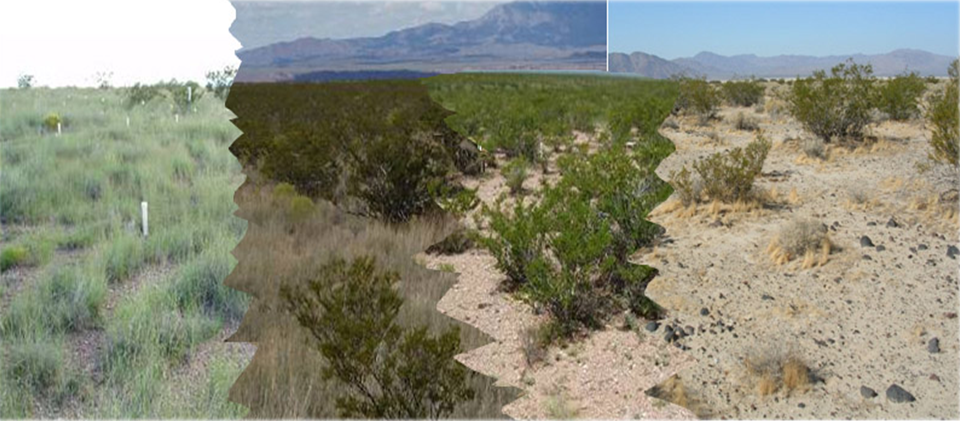

With the grassland on the left and the shrubland on the right.

The monitoring and initial modelling are described in detail in Turnbull et al. (2010a-c; 2011).

The data and scripts for the session can be found at: https://github.com/john-wainwright/Taiwan_workshop

Download the data folder and make sure you keep the data files separate from the script files for good working practice.  The code below was originally designed assuming this file is in a folder called scripts, and that the data folder is in the same project folder:

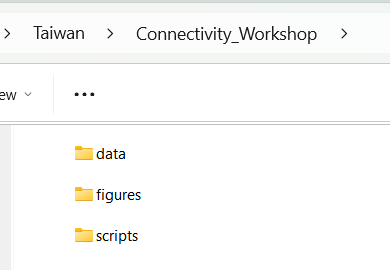

You can use the Connectivity_part_1.ipynb as a standalone Jupyter notebook on a local machine or the Connectivity_part_1.py as a standard python file (best interrogated using Spyder or an equivalent IDE).

In this Colab version, copy the data folder to the top folder of your Google Drive (or modify the paths below if you prefer to keep the data somewhere else).  If you upload this file "Connectivity_part_1_colab.ipynb" in the Colab, it will normally be placed in a folder called "Colab Notebooks".

You don't have to use this approach, but it keeps things tidy and aids replicability.  Note that there's also a folder called figures which you need to create to store the outputs in.  Again, it's assumed to be in your top Google Drive folder in the code below, but it's straightforward to change the paths.

We will undertake this analysis using several key python packages

  - Numpy - a mathematical operations package
  - Pandas - a data analysis and data manipulation tool
  - Matplotlib - a comprehensive library for creating visualizations
  - Rasterio - to allow import of raster data
  - Networkx - one of the main python libraries for analysing networks
  - Seaborn - for creating some of the visualizations more easily

First we import these packages and give them their standard Python aliases.  Rasterio isn't a standard Colab package, so the first line simply installs it from the standard repository.

In [4]:
!pip install rasterio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import rasterio as rio
import rasterio.plot
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.4 MB/s eta 0:00:00


Next, we will access our data for the practical.  The data are in the public repository at https://github.com/john-wainwright/Taiwan_workshop/data - see above about making a copy of this folder in your Google Drive.
We'll set up a variable pointing to this folder to make the subsequent code clearer, but it's also useful in that it makes it easier to change if you want to move the data folder later.  There's also a variable pointing to the folder where your figures output from this Colab will be stored.  Remember to create this folder on your Drive too.

In [45]:
from google.colab import drive
drive.mount('/content/drive')
dataFolder = "drive/MyDrive/data/"
figuresFolder = "drive/MyDrive/figures/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To start off with, we'll look at the DEM data for plot 1, the grassland.  We'll use the rasterio open and read functions to access the data from the repository.  Rasterio also allows us to access the metadata in the file, from which we'll access the cell size information.

In [36]:
p1DEMFile = rio.open (dataFolder + "p1dem.asc")
p1DEM = p1DEMFile.read (1)
cellSize = p1DEMFile.transform [0]

Let's plot the data to check all is OK.  We'll use the rasterio.plot function for plotting so it will take care of the spatial information when plotting:

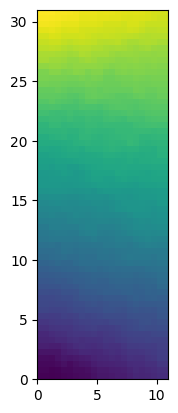

<Axes: >

In [37]:
fig, ax = plt.subplots ()
rio.plot.show (p1DEM, transform = p1DEMFile.transform)

So we can see that the plot is relatively planar and slopes down from the top to the bottom of the grid.


### Flowline Analysis

A basic building block for connectivity analysis is to understand the potential flowlines in the landscape.  We could do this analysis in GIS, but it's easier to incorporate it into our Python code for simplicity.  A further advantage of this approach is that we can use specific routines to allow us to replicate what is happening in the MAHLERAN model (Wainwright et al., 2008a-c), which for mathematical reasons routes flow in the four cardinal directions (N, S, E, W) rather than in eight directions as in most GIS software.

Because we'll want to carry out this analysis multiple times, we'll set up a function to calculate flow directions.  It requires the DEM and cell size as inputs, and outputs an array of values where 1 = "S", 2 = "W", 3 = "N", 4 = "E"; 0 = no outflow. Note that DEMs for our model input have a series of boundary cells that are used to calculate slopes, but are not inside the plots and aren't included in the model calculations or subsequent analyses.


In [38]:
def flowDirection4 (z, dx):
    '''
    calculate the cardinal flow direction from topography data using the steepest descent method


    Parameters
    ----------
    z : numpy array, float
        topography values representing the DEM.
    dx : float
        distance between cells in the DEM (assumed square).

    Returns
    -------
    direction : numpy array, integer
        flow direction code for the corresponding cell in the DEM.
          1 = "S", 2 = "W", 3 = "N", 4 = "E"; 0 = no outflow.

    '''
    m = [1, 0, -1, 0]
    n = [0, -1, 0, 1]

    rows, columns = z.shape
    direction = np.zeros ((rows, columns), dtype = int)

    for i in range (1, rows - 1):
        for j in range (1, columns - 1):
            if (np.isnan (z [i, j])):
                direction [i, j] = -9999
            else:
                slpMax = -9999.9
                for k in range (4):
                    inew = i + m [k]
                    jnew = j + n [k]
                    if (inew > 0 and inew < rows and jnew > 0 and jnew < columns):
                        slope = (z [i, j] - z [inew, jnew]) / dx
                        if (slope > slpMax):
                            slpMax = slope
                            direction [i, j] = k + 1
    return direction

Running the code cell above generates the function for further use.  Make sure you understand what the different steps in it are doing.

We can test our function using the p1DEM data and plot it out to have a look.


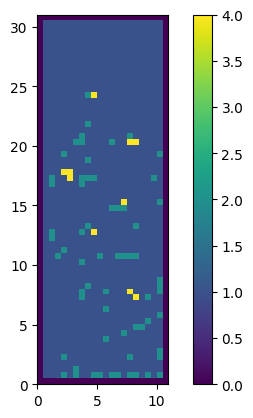

In [39]:
p1FlowDir = flowDirection4 (p1DEM, cellSize)

fig, ax = plt.subplots ()
plt.imshow (p1FlowDir, extent = rio.plot.plotting_extent (p1DEMFile))
plt.colorbar ()

Admittedly this isn't the most exciting image and it's not the best way to visualize the flowlines.

A better way to visualize the flowlines is to use a directed graph.  This approach will also come in useful later when we come to look at connectivity calculations and statistics.

Again, because it's something we'll need to use multiple times, we'll define it as a function.
The function will make use of the networkx functions to create and modify graphs:

  - nx.DiGraph () - sets up a new instance of a directed graph
  - add_nodes_from - adds nodes to the (directed) graph based on a list.  Here we generate a list of all our DEM points as nodes
  - add_edge - adds an edge to the (directed) graph going from one node to the next.  Note how the flow direction code needs only to be modified slightly to assess where the edges are

We also need to create a dictionary of x, y coordinates of each of the nodes so that they can be plotted in the correct locations.

In [40]:
def createDigraphFromDEM (z, zFile, direction):
    '''
    Makes a networkx directed graph from DEM and flow direction data.
    Assumes flow direction codes for the corresponding cell in the DEM as follows:
      1 = "S", 2 = "W", 3 = "N", 4 = "E"; 0 = no outflow.
    Other values are ignored.

    Parameters
    ----------
    z : numpy array, float
        topography values representing the DEM.
    zFile : io.DatasetReader
        file containing the DEM values corresponding to z (needed to extract
                                                           geometry information).
    direction : numpy array, integer
        flow direction code for the corresponding cell in the DEM.

    Returns
    -------
    newFlowGraph : networkx directed graph
        directed graph with the directions determined by the flow direction.
    geometry : dictionary
        x and y values for each node in the directed graph allowing it to be
          plotted geographically.

    '''
    m = [1, 0, -1, 0]
    n = [0, -1, 0, 1]
    newFlowGraph = nx.DiGraph ()

    rows, columns = z.shape
    nodes = np.arange (0, rows * columns).tolist ()
    newFlowGraph.add_nodes_from (nodes)

    thisNode = 0
    geometry = {}
    for i in range (rows):
        for j in range (columns):
            geometry.update ({thisNode: zFile.xy (i, j)})
            thisNode = thisNode + 1

    for i in range (1, rows - 1):
        for j in range (1, columns - 1):
            if (p1FlowDir [i, j] > 0):
                thisNode = i * columns + j
                if (direction [i, j] > 0 and direction [i, j] < 5):
                    thisDir = direction [i, j] - 1
                    inew = i + m [thisDir]
                    jnew = j + n [thisDir]
                    nextNode = inew * columns + jnew
                    newFlowGraph.add_edge (thisNode, nextNode)

    return newFlowGraph, geometry

So to test the function, we'll again use the p1DEM data, and note that the flow-direction data already calculated are an input to the function.

We use the networkx draw_networkx_edges function to plot out the results.

Note that the code saves a copy of this figure to a folder called ../figures relative to the location of the script.  If this folder doesn't exist, this part of the code chunk will fail.  Create the folder beforehand, or change the path, or comment out that line.

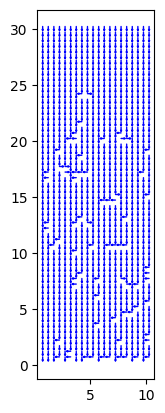

In [44]:
p1FlowGraph, p1FlowGraphGeom = createDigraphFromDEM (p1DEM, p1DEMFile, p1FlowDir)

fig, ax = plt.subplots ()
nx.draw_networkx_edges (p1FlowGraph, pos = p1FlowGraphGeom, ax = ax,
                        arrows = True, arrowsize = 2, width = 1, edge_color = "b")
limits = plt.axis ('on')
plt.axis ('scaled')
ax.autoscale (tight = True)
ax.tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
plt.savefig (figuresFolder + "p1FlowGraph.png")
plt.show ()


So we now have a clearer representation of the flowlines.  Have a play with the arrowsize and width values in the call to nx.draw_networkx_edges to see how they make things better (or worse!).

Before moving on, let's have a look at what the DEMs and flow lines look like for the other plots too:


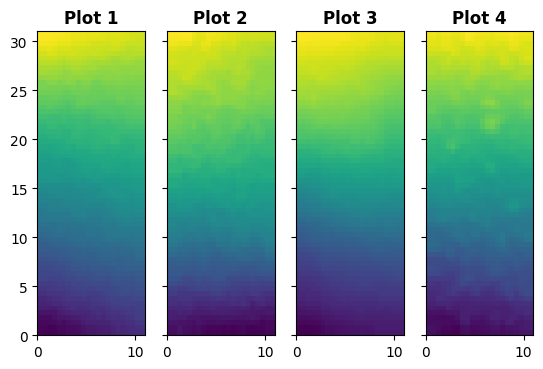

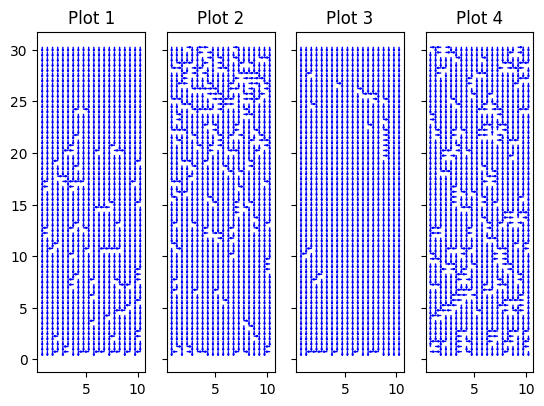

In [46]:
p2DEMFile = rio.open (dataFolder + "p2dem.asc")
p2DEM = p2DEMFile.read (1)
p3DEMFile = rio.open (dataFolder + "p3dem.asc")
p3DEM = p3DEMFile.read (1)
p4DEMFile = rio.open (dataFolder + "p4dem.asc")
p4DEM = p4DEMFile.read (1)

fig, axs = plt.subplots (1, 4)
rio.plot.show (p1DEM, transform = p1DEMFile.transform, ax = axs [0], title = "Plot 1")
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
rio.plot.show (p2DEM, transform = p2DEMFile.transform, ax = axs [1], title = "Plot 2")
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
rio.plot.show (p3DEM, transform = p3DEMFile.transform, ax = axs [2], title = "Plot 3")
axs [2].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
rio.plot.show (p4DEM, transform = p4DEMFile.transform, ax = axs [3], title = "Plot 4")
axs [3].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)

p2FlowDir = flowDirection4 (p2DEM, cellSize)
p3FlowDir = flowDirection4 (p3DEM, cellSize)
p4FlowDir = flowDirection4 (p4DEM, cellSize)

p2FlowGraph, p2FlowGraphGeom = createDigraphFromDEM (p2DEM, p2DEMFile, p2FlowDir)
p3FlowGraph, p3FlowGraphGeom = createDigraphFromDEM (p3DEM, p3DEMFile, p3FlowDir)
p4FlowGraph, p4FlowGraphGeom = createDigraphFromDEM (p4DEM, p4DEMFile, p4FlowDir)

fig, axs = plt.subplots (1, 4)
nx.draw_networkx_edges (p1FlowGraph, pos = p1FlowGraphGeom, ax = axs [0],
                        arrows = True, arrowsize = 2, width = 1, edge_color = "b")
axs [0].autoscale (tight = True)
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [0].title.set_text ("Plot 1")
nx.draw_networkx_edges (p2FlowGraph, pos = p2FlowGraphGeom, ax = axs [1],
                        arrows = True, arrowsize = 2, width = 1, edge_color = "b")
axs [1].autoscale (tight = True)
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [1].title.set_text ("Plot 2")
nx.draw_networkx_edges (p3FlowGraph, pos = p3FlowGraphGeom, ax = axs [2],
                        arrows = True, arrowsize = 2, width = 1, edge_color = "b")
axs [2].autoscale (tight = True)
axs [2].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [2].title.set_text ("Plot 3")
nx.draw_networkx_edges (p4FlowGraph, pos = p4FlowGraphGeom, ax = axs [3],
                        arrows = True, arrowsize = 2, width = 1, edge_color = "b")
axs [3].autoscale (tight = True)
axs [3].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [3].title.set_text ("Plot 4")
limits = plt.axis ('on')
axs [0].axis ('scaled')
axs [1].axis ('scaled')
axs [2].axis ('scaled')
axs [3].axis ('scaled')
plt.savefig (figuresFolder + "PlotsFlowGraph.png")
plt.show ()

Although there's a lot of code here, note how it's mostly repetitive (and a lot of it is just to tidy the figures).  It's reading in each of the other DEMs, calculating the flow directions from them, and building the directed graphs from that data.

We're now ready to look at some connectivity.


### Structural Connectivity

In Turnbull and Wainwright (2019) and Tiwari et al. (2025), we use vegetation cover with a threshold value of 60% to estimate where flow pathways are stopped by the presence of vegetation cover. This value is based on percolation theory, and has been demonstrated in other contexts in connectivity studies (e.g. Harel and Mouche, 2014).

First let's get our vegetation data and plot them out to check they look OK:

<Axes: title={'center': 'Plot 4'}>

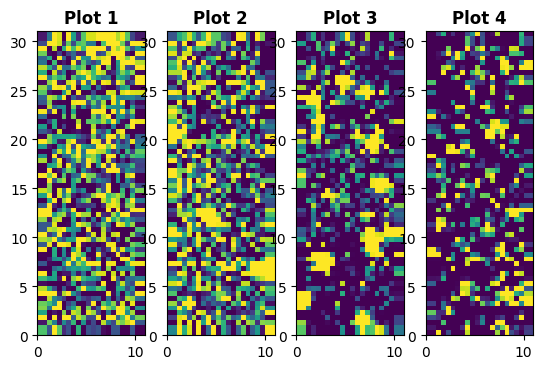

In [47]:
p1VegFile = rio.open (dataFolder + "p1vegcover.asc")
p1Veg = p1VegFile.read (1)
p2VegFile = rio.open (dataFolder + "p2vegcover.asc")
p2Veg = p2VegFile.read (1)
p3VegFile = rio.open (dataFolder + "p3vegcover.asc")
p3Veg = p3VegFile.read (1)
p4VegFile = rio.open (dataFolder + "p4vegcover.asc")
p4Veg = p4VegFile.read (1)

fig, axs = plt.subplots (1, 4)
rio.plot.show (p1Veg, transform = p1VegFile.transform, ax = axs [0], title = "Plot 1")
rio.plot.show (p2Veg, transform = p2VegFile.transform, ax = axs [1], title = "Plot 2")
rio.plot.show (p3Veg, transform = p3VegFile.transform, ax = axs [2], title = "Plot 3")
rio.plot.show (p4Veg, transform = p4VegFile.transform, ax = axs [3], title = "Plot 4")


We'll create a new function createSCDigraph that takes the DEM and flow direction data again as parameters, as well as the map of vegetation cover.  The threshold vegetation is set as a default of 60 %, so it's optional to specify it each time, but allows us to evaluate what happens as that threshold changes.

Note again that the function is very similar to the ones that have gone before.  We simply check if the vegetation cover in the destination cell is less than the threshold, and only create an edge if it is.  The function also calculates a weight to estimate the strength of connectivity: it scales from 0 where vegetation cover is at or above the threshold, to 1 where there is no vegetation cover.


In [48]:
def createSCDigraph (z, zFile, direction, veg, vegThreshold = 60.):
    '''
    Makes a networkx directed graph from DEM and flow direction data.
    Uses vegetation data to disconnect structural flows above a given threshold.
    Assumes flow direction codes for the corresponding cell in the DEM as follows:
      1 = "S", 2 = "W", 3 = "N", 4 = "E"; 0 = no outflow.
    Other values are ignored.

    Parameters
    ----------
    z : numpy array, float
        topography values representing the DEM.
    zFile : io.DatasetReader
        file containing the DEM values corresponding to z (needed to extract
                                                           geometry information).
    direction : numpy array, integer
        flow direction code for the corresponding cell in the DEM.
    veg : numpy array, float
        vegetation cover in percent for the same cells as the topography.
    vegThreshold : float
        threshold value for vegetation cover to break the connectivity in
           flow.  Default = 60 based on percolation theory.

    Returns
    -------
    newFlowGraph : networkx directed graph
        directed graph with the directions determined by the flow direction
        but with connexions broken.
        Contains a weight parameter which is the inverse of the vegetation
          relative to the threshold = (vegThreshold - veg) / vegThreshold
    geometry : dictionary
        x and y values for each node in the directed graph allowing it to be
          plotted geographically.

    '''
    m = [1, 0, -1, 0]
    n = [0, -1, 0, 1]
    newFlowGraph = nx.DiGraph ()

    rows, columns = z.shape
    nodes = np.arange (0, rows * columns).tolist ()
    newFlowGraph.add_nodes_from (nodes)

    thisNode = 0
    geometry = {}
    for i in range (rows):
        for j in range (columns):
            geometry.update ({thisNode: zFile.xy (i, j)})
            thisNode = thisNode + 1

    for i in range (1, rows - 1):
        for j in range (1, columns - 1):
            if (p1FlowDir [i, j] > 0):
                thisNode = i * columns + j
                if (direction [i, j] > 0 and direction [i, j] < 5):
                    thisDir = direction [i, j] - 1
                    inew = i + m [thisDir]
                    jnew = j + n [thisDir]
                    if (veg [inew, jnew] < vegThreshold):
                        nextNode = inew * columns + jnew
                        vegWeight = (vegThreshold - veg [inew, jnew]) / vegThreshold
                        newFlowGraph.add_edge (thisNode, nextNode,
                                               weight = vegWeight)

    return newFlowGraph, geometry

We'll test again with the grassland plot.  In this case, we'll plot out the results with the widths of the flowlines being proportional to the connectivity weights we've generated.  Because of the way nx.draw_networkx_edges works, we need to take the edges as a list, and extract a list of weights that map onto them to pass to the width value.

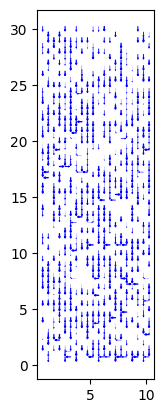

In [49]:
p1SCGraph, p1SCGraphGeom = createSCDigraph (p1DEM, p1DEMFile, p1FlowDir,
                                            p1Veg, vegThreshold = 60.)
edgesP1SC = p1SCGraph.edges ()
weightsP1SC = [p1SCGraph [u][v]['weight'] for u,v in edgesP1SC]

fig, ax = plt.subplots ()
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = ax,
                        arrows = True, arrowsize = 2, width = weightsP1SC,
                        edge_color = "b")
limits = plt.axis ('on')
plt.axis ('scaled')
ax.autoscale (tight = True)
ax.tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
plt.savefig (figuresFolder + "p1SCGraph.png")
plt.show ()


Note where the patterns are different here from the initial flowlines.  (As an exercise, you could plot the two next to each other to make it easier to compare them.)

Now let's repeat the process for the other plots:

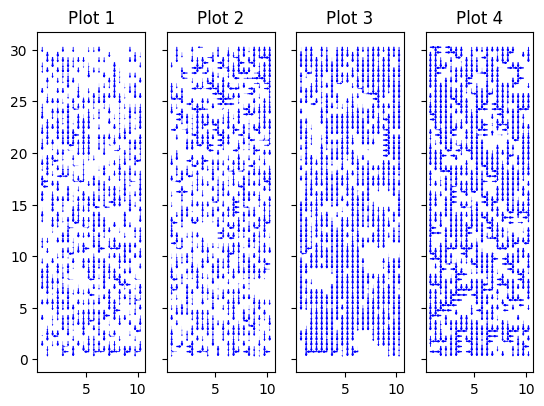

In [50]:
p2SCGraph, p2SCGraphGeom = createSCDigraph (p2DEM, p2DEMFile, p2FlowDir,
                                            p2Veg, vegThreshold = 60.)
edgesP2SC = p2SCGraph.edges ()
weightsP2SC = [p2SCGraph [u][v]['weight'] for u,v in edgesP2SC]
p3SCGraph, p3SCGraphGeom = createSCDigraph (p3DEM, p3DEMFile, p3FlowDir,
                                            p3Veg, vegThreshold = 60.)
edgesP3SC = p3SCGraph.edges ()
weightsP3SC = [p3SCGraph [u][v]['weight'] for u,v in edgesP3SC]
p4SCGraph, p4SCGraphGeom = createSCDigraph (p4DEM, p4DEMFile, p4FlowDir,
                                            p4Veg, vegThreshold = 60.)
edgesP4SC = p4SCGraph.edges ()
weightsP4SC = [p4SCGraph [u][v]['weight'] for u,v in edgesP4SC]

fig, axs = plt.subplots (1, 4)
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0],
                        arrows = True, arrowsize = 2, width = weightsP1SC,
                        edge_color = "b")
axs [0].autoscale (tight = True)
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [0].title.set_text ("Plot 1")
nx.draw_networkx_edges (p2SCGraph, pos = p2SCGraphGeom, ax = axs [1],
                        arrows = True, arrowsize = 2, width = weightsP2SC,
                        edge_color = "b")
axs [1].autoscale (tight = True)
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [1].title.set_text ("Plot 2")
nx.draw_networkx_edges (p3SCGraph, pos = p3SCGraphGeom, ax = axs [2],
                        arrows = True, arrowsize = 2, width = weightsP3SC,
                        edge_color = "b")
axs [2].autoscale (tight = True)
axs [2].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [2].title.set_text ("Plot 3")
nx.draw_networkx_edges (p4SCGraph, pos = p4SCGraphGeom, ax = axs [3],
                        arrows = True, arrowsize = 2, width = weightsP4SC,
                        edge_color = "b")
axs [3].autoscale (tight = True)
axs [3].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [3].title.set_text ("Plot 4")
axs [0].axis ('scaled')
axs [1].axis ('scaled')
axs [2].axis ('scaled')
axs [3].axis ('scaled')
plt.savefig (figuresFolder + "PlotsSCGraph.png")
plt.show ()


Note again that most of this code is to tidy the images.

We can compare the weights for the different plots using a boxplot.  The first part of the following code block creates a pandas DataFrame in long format, i.e. all the values of weights are in a single column of data, with a second column to note which plot they were calculated for.

Once we have all the weights, we can use the seaborn boxplot function (rather than the base matplotlib one) as it knows how to separate the values of the weights according to the column with the plot categories in.


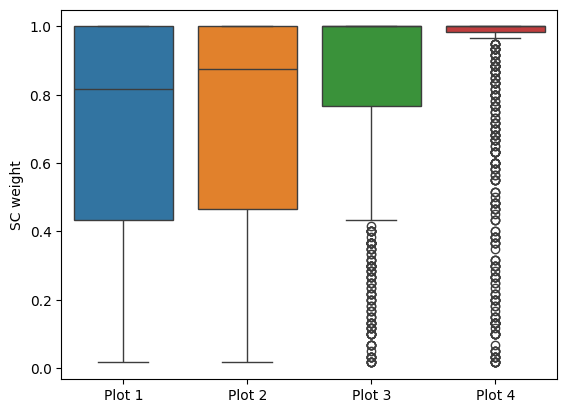

In [51]:
weightsSC = pd.DataFrame ({"weight": weightsP1SC,
                           "plot": np.repeat ("Plot 1", len (weightsP1SC))})

weightsSC = pd.concat ([weightsSC,
                       pd.DataFrame ({"weight": weightsP2SC,
                                      "plot": np.repeat ("Plot 2",
                                                         len (weightsP2SC))})])
weightsSC = pd.concat ([weightsSC,
                       pd.DataFrame ({"weight": weightsP3SC,
                                      "plot": np.repeat ("Plot 3",
                                                         len (weightsP3SC))})])
weightsSC = pd.concat ([weightsSC,
                       pd.DataFrame ({"weight": weightsP4SC,
                                      "plot": np.repeat ("Plot 4",
                                                         len (weightsP4SC))})])

fig, ax = plt.subplots ()
SCBoxplot = sns.boxplot (data = weightsSC, x = "plot", y = "weight",
                         hue = "plot", ax = ax)
SCBoxplot.set (xlabel = "", ylabel = "SC weight")
plt.show ()



What might these patterns suggest in terms of the structural connectivity of the four plots (remember that 1 = Grassland and 4 = Shrubland end-members)?

Note that the pandas DataFrame also allows us to calculate statistical summaries of these data very easily:

In [52]:
weightsSC.groupby ("plot").describe ()

weight                                                            
        count      mean       std       min       25%       50%  75%  max
plot                                                                     
Plot 1  749.0  0.694927  0.330554  0.016667  0.433333  0.816667  1.0  1.0
Plot 2  830.0  0.716004  0.327486  0.016667  0.466667  0.875000  1.0  1.0
Plot 3  949.0  0.843906  0.265809  0.016667  0.766667  1.000000  1.0  1.0
Plot 4  986.0  0.890805  0.243120  0.016667  0.983333  1.000000  1.0  1.0


### Functional Connectivity

Direct measurements of functional connectivity are very difficult in this context, so we have used the MAHLERAN model to estimate it.  The data folder contains a series of output files from model simulations for a range of scenarios of rainfall intensity and initial soil moisture for each of the four plots.  The rationale for the scenarios is discussed fully in Turnbull and Wainwright (2019).

For each of the four plot types (grassland = 1, grass/shrub = 2, shrub/grass = 3, shrubland = 4), there are five rainfall scenarios (A = 45 mm, B = 24 mm, C = 15 mm, D = 10 mm, E = 5 mm) and three initial soil-moisture conditions (low = 3.8 %, med = 10.5 %, high = 21.1%).  Each of the scenarios have outputs for total event runoff and total event sediment flux.  The file names reflect the scenarios, so for example:

  - p1_rainA_highsm_dschg.asc is the flow (dschg = discharge) output for the grassland plot, with the 45 mm rainfall event and 21.1 % initial soil moisture.
  - p4_rainC_lowsm_dschg.asc is the flow for the shrubland plot with the 15 mm rainfall event and 3.8 % initial soil-moisture content.

Let's read in and look at the first of these:

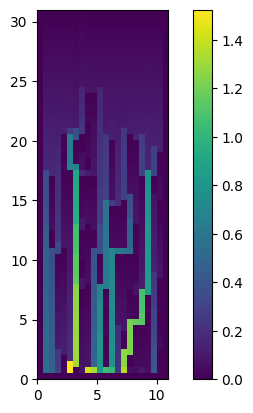

In [53]:
p1AHighQFile = rio.open (dataFolder + "p1_rainA_highsm_dschg.asc")
p1AHighQ = p1AHighQFile.read (1)

fig, ax = plt.subplots ()
plt.imshow (p1AHighQ, extent = rio.plot.plotting_extent (p1DEMFile))
plt.colorbar ()

Flow lines and concentrations can be seen.  The values are total event runoff in litres.

#### Flow connectivity

We estimate the functional connectivity in a similar way to the structural connectivity, but using a threshold from the flow values.

The same D4 steepest descent flow routing is used, and the flow threshold has a default value of 0.8 mm depth (equivalent to 0.249 L for 0.5 × 0.5 m cells), above which the water is considered to be functionally flowing between cells.  We again calculate a weight for each edge by scaling between the threshold value (where the weight = 0) and the maximum simulated flux in any of the events, which was 3.86 L.

Again note how we can create a function based on the previous ones by making small modifications.

In [54]:

def createFlowFCDigraph (z, zFile, direction, flow,
                         flowThreshold = 0.249, maxFlow = 3.86):
    '''
    Makes a networkx directed graph from DEM and flow direction data.
    Flow connectivity occurs if flows are above a given threshold
    Assumes flow direction codes for the corresponding cell in the DEM as follows:
      1 = "S", 2 = "W", 3 = "N", 4 = "E"; 0 = no outflow.
    Other values are ignored.

    Parameters
    ----------
    z : numpy array, float
        topography values representing the DEM.
    zFile : io.DatasetReader
        file containing the DEM values corresponding to z (needed to extract
                                                           geometry information).
    direction : numpy array, integer
        flow direction code for the corresponding cell in the DEM.
    flow : numpy array, float
        flow discharge in L for the same cells as the topography.
    flowThreshold : float
        threshold value for flow to produce functional connectivity
        Default = 0.249 L.
    maxFlow : float
        upper limit of flows to be compared, used to scale weightings
        Default = 3.86 L based on simulations in the Tiwari et al. (2025) paper

    Returns
    -------
    newFlowGraph : networkx directed graph
        directed graph with the directions determined by the flow direction
        but with connexions broken.
        Contains a weight parameter which is the flow scaled by a maximum
           flow rate (based on a range of simulations)
    geometry : dictionary
        x and y values for each node in the directed graph allowing it to be
          plotted geographically.

    '''
    m = [1, 0, -1, 0]
    n = [0, -1, 0, 1]
    newFlowGraph = nx.DiGraph ()

    rows, columns = z.shape
    nodes = np.arange (0, rows * columns).tolist ()
    newFlowGraph.add_nodes_from (nodes)

    thisNode = 0
    geometry = {}
    for i in range (rows):
        for j in range (columns):
            geometry.update ({thisNode: zFile.xy (i, j)})
            thisNode = thisNode + 1

    for i in range (1, rows - 1):
        for j in range (1, columns - 1):
            if (p1FlowDir [i, j] > 0):
                thisNode = i * columns + j
                if (direction [i, j] > 0 and direction [i, j] < 5 and
                    flow [i, j] >= flowThreshold):
                    thisDir = direction [i, j] - 1
                    inew = i + m [thisDir]
                    jnew = j + n [thisDir]
                    nextNode = inew * columns + jnew
                    flowWeight = (flow [i, j] - flowThreshold) / (maxFlow - flowThreshold)
                    newFlowGraph.add_edge (thisNode, nextNode,
                                           weight = flowWeight)

    return newFlowGraph, geometry

The resulting flow functional connectivity for the high rainfall, high initial soil moisture event on the grassland is as follows:


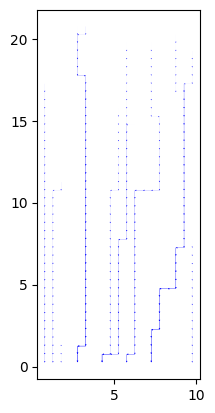

In [55]:
p1AHighQFlowFCGraph, p1AHighQFlowFCGraphGeom = createFlowFCDigraph (p1DEM, p1DEMFile,
                                                                    p1FlowDir,
                                                                    p1AHighQ,
                                                                    flowThreshold = 0.249,
                                                                    maxFlow = 3.86)
edgesP1AHighQFlowFC = p1AHighQFlowFCGraph.edges ()
weightsP1AHighQFlowFC = [p1AHighQFlowFCGraph [u][v]['weight'] for u,v in edgesP1AHighQFlowFC]

fig, ax = plt.subplots ()
nx.draw_networkx_edges (p1AHighQFlowFCGraph, pos = p1AHighQFlowFCGraphGeom, ax = ax,
                        arrows = True, arrowsize = 2, width = weightsP1AHighQFlowFC,
                        edge_color = "b")
limits = plt.axis ('on')
plt.axis ('scaled')
ax.autoscale (tight = True)
ax.tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
plt.savefig (figuresFolder + "p1AHighQFlowFCGraph.png")
plt.show ()

Again, you could experiment with the values of the flowThreshold and maxFlow parameters to see how sensitive the functional connectivity estimate is to them.

#### Sediment-Transport Connectivity

The total sediment transport simulation outputs are in a series of files labelled in the same way as the flow data, but with _sedtr rather than _dschg as the final part of the name.

Let's read in the sediment-transport data for the same event as above:

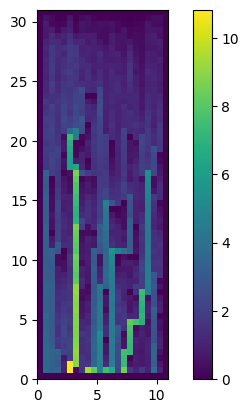

In [56]:
p1AHighSedFile = rio.open (dataFolder + "p1_rainA_highsm_sedtr.asc")
p1AHighSed = p1AHighSedFile.read (1)

fig, ax = plt.subplots ()
plt.imshow (p1AHighSed, extent = rio.plot.plotting_extent (p1AHighSedFile))
plt.colorbar ()

The values are total sediment transport in g.

The sediment-transport functional connectivity is calculated in the same way as the flow functional connectivity, just with different thresholds.  The lower threshold is based on estimates of when diffusive sediment transport by splash is dominant.  The upper threshold is again based on the highest values simulated.


In [57]:
def createSedFCDigraph (z, zFile, direction, sedTrans,
                        sedThreshold = 1.0, maxSed = 14.18):
    '''
    Makes a networkx directed graph from DEM and flow direction data.
    Sediment connectivity occurs if transport is above a given threshold
    Assumes flow direction codes for the corresponding cell in the DEM as follows:
      1 = "S", 2 = "W", 3 = "N", 4 = "E"; 0 = no outflow.
    Other values are ignored.

    Parameters
    ----------
    z : numpy array, float
        topography values representing the DEM.
    zFile : io.DatasetReader
        file containing the DEM values corresponding to z (needed to extract
                                                           geometry information).
    direction : numpy array, integer
        flow direction code for the corresponding cell in the DEM.
    sedTrans : numpy array, float
        sedimentTransport in g for the same cells as the topography.
    flowThreshold : float
        threshold value for flow to produce functional connectivity
        Default = 1 g.
    maxSed : float
        upper limit of sediment transport to be compared, used to scale weightings
        Default = 14.18 g based on simulations in the Tiwari et al. (2025) paper

    Returns
    -------
    newFlowGraph : networkx directed graph
        directed graph with the directions determined by the flow direction
        but with connexions broken.
        Contains a weight parameter which is the sediment transport scaled by a
          maximum transport rate (based on a range of simulations)
    geometry : dictionary
        x and y values for each node in the directed graph allowing it to be
          plotted geographically.

    '''
    m = [1, 0, -1, 0]
    n = [0, -1, 0, 1]
    newFlowGraph = nx.DiGraph ()

    rows, columns = z.shape
    nodes = np.arange (0, rows * columns).tolist ()
    newFlowGraph.add_nodes_from (nodes)

    thisNode = 0
    geometry = {}
    for i in range (rows):
        for j in range (columns):
            geometry.update ({thisNode: zFile.xy (i, j)})
            thisNode = thisNode + 1

    for i in range (1, rows - 1):
        for j in range (1, columns - 1):
            if (p1FlowDir [i, j] > 0):
                thisNode = i * columns + j
                if (direction [i, j] > 0 and direction [i, j] < 5 and
                    sedTrans [i, j] >= sedThreshold):
                    thisDir = direction [i, j] - 1
                    inew = i + m [thisDir]
                    jnew = j + n [thisDir]
                    nextNode = inew * columns + jnew
                    sedWeight = (sedTrans [i, j] - sedThreshold) / (maxSed - sedThreshold)
                    newFlowGraph.add_edge (thisNode, nextNode,
                                           weight = sedWeight)

    return newFlowGraph, geometry

(You might notice that we don't actually need different functions for the two types of functional connectivity -- the distinction is simply made for clarity as we progress.)

The functional connectivity for this event for sediment transport is thus:

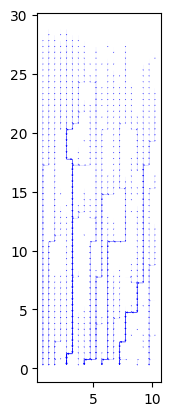

In [58]:
p1AHighQSedFCGraph, p1AHighQSedFCGraphGeom = createSedFCDigraph (p1DEM, p1DEMFile,
                                                                 p1FlowDir,
                                                                 p1AHighSed,
                                                                 sedThreshold = 1.0,
                                                                 maxSed = 14.18)
edgesP1AHighQSedFC = p1AHighQSedFCGraph.edges ()
weightsP1AHighQSedFC = [p1AHighQSedFCGraph [u][v]['weight'] for u,v in edgesP1AHighQSedFC]

fig, ax = plt.subplots ()
nx.draw_networkx_edges (p1AHighQSedFCGraph, pos = p1AHighQSedFCGraphGeom, ax = ax,
                        arrows = True, arrowsize = 2, width = weightsP1AHighQSedFC,
                        edge_color = "b")
limits = plt.axis ('on')
plt.axis ('scaled')
ax.autoscale (tight = True)
ax.tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
plt.savefig (figuresFolder + "p1AHighQSedFCGraph.png")
plt.show ()


And because it's easier to compare the structural and functional connectivities if we plot them side-by-side, let's do that:

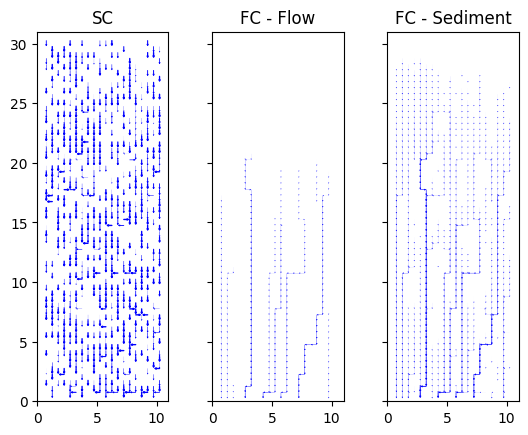

In [59]:
fig, axs = plt.subplots (1, 3)
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0],
                        arrows = True, arrowsize = 2, width = weightsP1SC,
                        edge_color = "b")
axs [0].autoscale (tight = True)
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [0].title.set_text ("SC")
nx.draw_networkx_edges (p1AHighQFlowFCGraph, pos = p1AHighQFlowFCGraphGeom, ax = axs [1],
                        arrows = True, arrowsize = 2, width = weightsP1AHighQFlowFC,
                        edge_color = "b")
axs [1].autoscale (tight = True)
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [1].title.set_text ("FC - Flow")
nx.draw_networkx_edges (p1AHighQSedFCGraph, pos = p1AHighQSedFCGraphGeom, ax = axs [2],
                        arrows = True, arrowsize = 2, width = weightsP1AHighQSedFC,
                        edge_color = "b")
axs [2].autoscale (tight = True)
axs [2].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [2].title.set_text ("FC - Sediment")
axs [0].axis ('scaled')
axs [1].axis ('scaled')
axs [2].axis ('scaled')
axs [0].set_xlim ([0, 11])
axs [0].set_ylim ([0, 31])
axs [1].set_xlim ([0, 11])
axs [1].set_ylim ([0, 31])
axs [2].set_xlim ([0, 11])
axs [2].set_ylim ([0, 31])
plt.savefig (figuresFolder + "p1AHighQSCFCGraph.png")
plt.show ()

Comparing the same event for the shrubland:

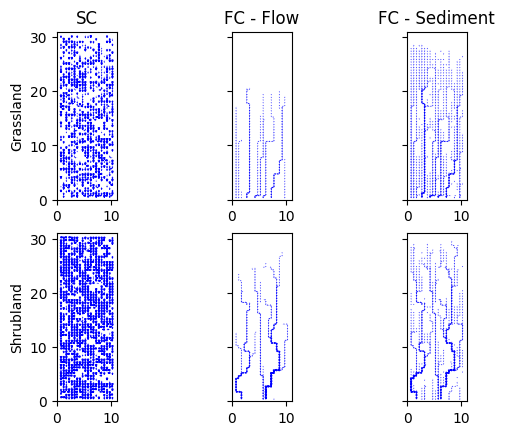

In [60]:
p4AHighQFile = rio.open (dataFolder + "p4_rainA_highsm_dschg.asc")
p4AHighQ = p4AHighQFile.read (1)

p4AHighQFlowFCGraph, p4AHighQFlowFCGraphGeom = createFlowFCDigraph (p4DEM, p4DEMFile,
                                                                    p4FlowDir,
                                                                    p4AHighQ,
                                                                    flowThreshold = 0.249,
                                                                    maxFlow = 3.86)
edgesP4AHighQFlowFC = p4AHighQFlowFCGraph.edges ()
weightsP4AHighQFlowFC = [p4AHighQFlowFCGraph [u][v]['weight'] for u,v in edgesP4AHighQFlowFC]

p4AHighSedFile = rio.open (dataFolder + "p4_rainA_highsm_sedtr.asc")
p4AHighSed = p4AHighSedFile.read (1)

p4AHighQSedFCGraph, p4AHighQSedFCGraphGeom = createSedFCDigraph (p4DEM, p4DEMFile,
                                                                 p4FlowDir,
                                                                 p4AHighSed,
                                                                 sedThreshold = 1.0,
                                                                 maxSed = 14.18)
edgesP4AHighQSedFC = p4AHighQSedFCGraph.edges ()
weightsP4AHighQSedFC = [p4AHighQSedFCGraph [u][v]['weight'] for u,v in edgesP4AHighQSedFC]

fig, axs = plt.subplots (2, 3)
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0, 0],
                        arrows = True, arrowsize = 2, width = weightsP1SC,
                        edge_color = "b")
nx.draw_networkx_edges (p1AHighQFlowFCGraph, pos = p1AHighQFlowFCGraphGeom, ax = axs [0, 1],
                        arrows = True, arrowsize = 2, width = weightsP1AHighQFlowFC,
                        edge_color = "b")
nx.draw_networkx_edges (p1AHighQSedFCGraph, pos = p1AHighQSedFCGraphGeom, ax = axs [0, 2],
                        arrows = True, arrowsize = 2, width = weightsP1AHighQSedFC,
                        edge_color = "b")
nx.draw_networkx_edges (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1, 0],
                        arrows = True, arrowsize = 2, width = weightsP4SC,
                        edge_color = "b")
nx.draw_networkx_edges (p4AHighQFlowFCGraph, pos = p4AHighQFlowFCGraphGeom, ax = axs [1, 1],
                        arrows = True, arrowsize = 2, width = weightsP4AHighQFlowFC,
                        edge_color = "b")
nx.draw_networkx_edges (p4AHighQSedFCGraph, pos = p4AHighQSedFCGraphGeom, ax = axs [1, 2],
                        arrows = True, arrowsize = 2, width = weightsP4AHighQSedFC,
                        edge_color = "b")
axs [0, 0].axis ('scaled')
axs [0, 1].axis ('scaled')
axs [0, 2].axis ('scaled')
axs [1, 0].axis ('scaled')
axs [1, 1].axis ('scaled')
axs [1, 2].axis ('scaled')
axs [0, 0].autoscale (tight = True)
axs [0, 1].autoscale (tight = True)
axs [0, 2].autoscale (tight = True)
axs [1, 0].autoscale (tight = True)
axs [1, 1].autoscale (tight = True)
axs [1, 2].autoscale (tight = True)
axs [0, 0].set_xlim ([0, 11])
axs [0, 0].set_ylim ([0, 31])
axs [0, 1].set_xlim ([0, 11])
axs [0, 1].set_ylim ([0, 31])
axs [0, 2].set_xlim ([0, 11])
axs [0, 2].set_ylim ([0, 31])
axs [1, 0].set_xlim ([0, 11])
axs [1, 0].set_ylim ([0, 31])
axs [1, 1].set_xlim ([0, 11])
axs [1, 1].set_ylim ([0, 31])
axs [1, 2].set_xlim ([0, 11])
axs [1, 2].set_ylim ([0, 31])
axs [0, 0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [0, 1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [0, 2].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [1, 0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [1, 1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [1, 2].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [0, 0].title.set_text ("SC")
axs [0, 1].title.set_text ("FC - Flow")
axs [0, 2].title.set_text ("FC - Sediment")
axs [0, 0].set_ylabel ("Grassland")
axs [1, 0].set_ylabel ("Shrubland")
plt.savefig (figuresFolder + "p1p4AHighQSCFCGraph.png")
plt.show ()

We can now compare the distributions of weights for the structural and functional connectivities for the grassland and shrubland end-members, using the same process as before.

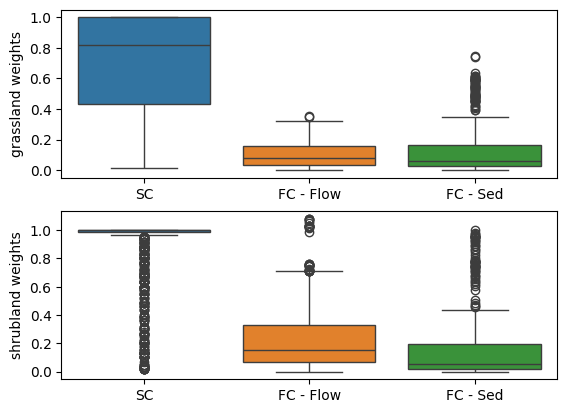

In [61]:
weightsSCFCp1 = pd.DataFrame ({"weight": weightsP1SC,
                               "connectivity": np.repeat ("SC", len (weightsP1SC))})

weightsSCFCp1 = pd.concat ([weightsSCFCp1,
                            pd.DataFrame ({"weight": weightsP1AHighQFlowFC,
                                           "connectivity": np.repeat ("FC - Flow",
                                                         len (weightsP1AHighQFlowFC))})])
weightsSCFCp1 = pd.concat ([weightsSCFCp1,
                            pd.DataFrame ({"weight": weightsP1AHighQSedFC,
                                           "connectivity": np.repeat ("FC - Sed",
                                                         len (weightsP1AHighQSedFC))})])
weightsSCFCp4 = pd.DataFrame ({"weight": weightsP4SC,
                               "connectivity": np.repeat ("SC", len (weightsP4SC))})

weightsSCFCp4 = pd.concat ([weightsSCFCp4,
                            pd.DataFrame ({"weight": weightsP4AHighQFlowFC,
                                           "connectivity": np.repeat ("FC - Flow",
                                                         len (weightsP4AHighQFlowFC))})])
weightsSCFCp4 = pd.concat ([weightsSCFCp4,
                            pd.DataFrame ({"weight": weightsP4AHighQSedFC,
                                           "connectivity": np.repeat ("FC - Sed",
                                                         len (weightsP4AHighQSedFC))})])

fig, axs = plt.subplots (2, 1)
SCBoxplot1 = sns.boxplot (data = weightsSCFCp1, x = "connectivity", y = "weight",
                         hue = "connectivity", ax = axs [0])
SCBoxplot1.set (xlabel = "", ylabel = "grassland weights")
SCBoxplot1 = sns.boxplot (data = weightsSCFCp4, x = "connectivity", y = "weight",
                         hue = "connectivity", ax = axs [1])
SCBoxplot1.set (xlabel = "", ylabel = "shrubland weights")
plt.show ()

And here are the summary statistics for the grassland:

In [62]:
weightsSCFCp1.groupby ("connectivity").describe ()

weight                                                    \
              count      mean       std       min       25%       50%   
connectivity                                                            
FC - Flow     288.0  0.106046  0.089035  0.000194  0.033931  0.078192   
FC - Sed      828.0  0.117255  0.141732  0.000076  0.026517  0.060395   
SC            749.0  0.694927  0.330554  0.016667  0.433333  0.816667   

                                  
                   75%       max  
connectivity                      
FC - Flow     0.154812  0.353365  
FC - Sed      0.162026  0.745068  
SC            1.000000  1.000000

And for the shrubland:

In [63]:
weightsSCFCp4.groupby ("connectivity").describe ()

weight                                                    \
              count      mean       std       min       25%       50%   
connectivity                                                            
FC - Flow     279.0  0.263506  0.281204  0.000000  0.069801  0.154860   
FC - Sed      638.0  0.159738  0.225566  0.000228  0.020732  0.056184   
SC            986.0  0.890805  0.243120  0.016667  0.983333  1.000000   

                                  
                   75%       max  
connectivity                      
FC - Flow     0.326502  1.078649  
FC - Sed      0.193873  1.003035  
SC            1.000000  1.000000

### Global Connectivity Metrics

In this section, we'll see how the algorithms built into the networkx library can be used to calculate metrics to represent the characteristics of the whole network.  We'll calculate values for the structural connectivity for plots 1-4; it should be straightforward to extend this approach to calculate the functional connectivity equivalents.

#### Centralization Degree

Measures how centralized connectivity is within a network. High CD indicates connectivity is concentrated through a few key nodes, making these nodes critical for overall system function.

In [64]:
p1SCDegCent = nx.degree_centrality (p1SCGraph)
p1SCDegCentNonZero = pd.Series (p1SCDegCent)[pd.Series (p1SCDegCent) > 0]
n = p1SCDegCentNonZero.count ()
p1SCCentDeg = sum (max (p1SCDegCentNonZero) - p1SCDegCentNonZero) / (n - 2)

p2SCDegCent = nx.degree_centrality (p2SCGraph)
p2SCDegCentNonZero = pd.Series (p2SCDegCent)[pd.Series (p2SCDegCent) > 0]
n = p2SCDegCentNonZero.count ()
p2SCCentDeg = sum (max (p2SCDegCentNonZero) - p2SCDegCentNonZero) / (n - 2)

p3SCDegCent = nx.degree_centrality (p3SCGraph)
p3SCDegCentNonZero = pd.Series (p3SCDegCent)[pd.Series (p3SCDegCent) > 0]
n = p3SCDegCentNonZero.count ()
p3SCCentDeg = sum (max (p3SCDegCentNonZero) - p3SCDegCentNonZero) / (n - 2)

p4SCDegCent = nx.degree_centrality (p4SCGraph)
p4SCDegCentNonZero = pd.Series (p4SCDegCent)[pd.Series (p4SCDegCent) > 0]
n = p4SCDegCentNonZero.count ()
p4SCCentDeg = sum (max (p4SCDegCentNonZero) - p4SCDegCentNonZero) / (n - 2)
print (p1SCCentDeg, p2SCCentDeg, p3SCCentDeg, p4SCCentDeg)


0.0018458813316068157 0.0017726393122159511 0.0009204787572453727 0.0016247582205029015


Conversion to pandas Series allows easy calculation based on each of the node values.  The zero values are removed to avoid edge effects.

#### General Efficiency

Represents the network’s ability to maintain connectivity, even when local connections are disrupted. Higher GE implies a more resilient network with efficient resource redistribution.

In [65]:
p1SCGE = pd.Series (nx.closeness_centrality (p1SCGraph)).sum ()
p2SCGE = pd.Series (nx.closeness_centrality (p2SCGraph)).sum ()
p3SCGE = pd.Series (nx.closeness_centrality (p3SCGraph)).sum ()
p4SCGE = pd.Series (nx.closeness_centrality (p4SCGraph)).sum ()
print (p1SCGE, p2SCGE, p3SCGE, p4SCGE)

0.7293378680052036 0.8714616154272956 1.1272913971010003 1.2536552936660064



#### Assortativity Coefficient

Quantifies the tendency of nodes to connect with others having similar (or dissimilar) traits. Positive AC indicates similar-node connections; negative AC indicates connections between dissimilar nodes.

In [66]:
p1SCAC = nx.degree_pearson_correlation_coefficient (p1SCGraph, weight = "weight")
p2SCAC = nx.degree_pearson_correlation_coefficient (p2SCGraph, weight = "weight")
p3SCAC = nx.degree_pearson_correlation_coefficient (p3SCGraph, weight = "weight")
p4SCAC = nx.degree_pearson_correlation_coefficient (p4SCGraph, weight = "weight")
print (p1SCAC, p2SCAC, p3SCAC, p4SCAC)

0.8015438519541369 0.757854191815222 0.8234530726909673 0.6031374720360062



### Local Connectivity Metrics

#### Weighted Mean Length of Connected Pathway

Weighted Mean Length of Connected Pathway (LOCOP) measures the weighted length of connected pathways reaching a node, highlighting its role in long-distance resource redistribution.

To create the distribution of values, we first need to use nx.shortest_path_length to produce a list for each node of the minimum distance from all nodes connected to them. In the second step, we take the list for each of the nodes and calculate the mean value.  Here are the average path lengths for the grassland and shrubland plots.

In [67]:
p1SCLOCOP = [nx.shortest_path_length (p1SCGraph, target = i, weight = "weight")
             for i in p1SCGraph]
p1SCMeanLOCOP = [np.array (list (p1SCLOCOP [i].values ())).mean ()
                 for i in range (len (p1SCLOCOP))]
p1SCWLOCOP = np.array (p1SCMeanLOCOP).mean ()

p4SCLOCOP = [nx.shortest_path_length (p4SCGraph, target = i, weight = "weight")
             for i in p4SCGraph]
p4SCMeanLOCOP = [np.array (list (p4SCLOCOP [i].values ())).mean ()
                 for i in range (len (p4SCLOCOP))]
p4SCWLOCOP = np.array (p4SCMeanLOCOP).mean ()

print (p1SCWLOCOP, p4SCWLOCOP)


0.47568885131759914 1.6492388786202894


We can then create a plot where the node size is a function of the mean LOCOP superimposed on the edges showing the structural connectivity.

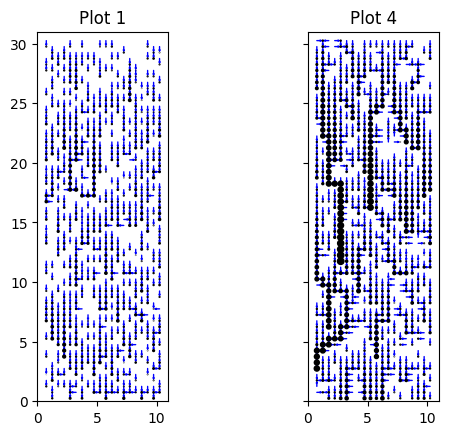

In [68]:
fig, axs = plt.subplots (1, 2)
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0],
                        arrows = True, arrowsize = 2, width = 1,
                        edge_color = "b")
nx.draw_networkx_nodes (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0], node_size = p1SCMeanLOCOP, node_color = "k")
nx.draw_networkx_edges (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1],
                        arrows = True, arrowsize = 2, width = 1,
                        edge_color = "b")
nx.draw_networkx_nodes (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1], node_size = p4SCMeanLOCOP, node_color = "k")
limits = plt.axis ('on')
axs [0].axis ('scaled')
axs [1].axis ('scaled')
axs [0].autoscale (tight = True)
axs [1].autoscale (tight = True)
axs [0].set_xlim ([0, 11])
axs [0].set_ylim ([0, 31])
axs [1].set_xlim ([0, 11])
axs [1].set_ylim ([0, 31])
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [0].title.set_text ("Plot 1")
axs [1].title.set_text ("Plot 4")
plt.savefig (figuresFolder + "p1p4SCMeanLocopGraph.png")
plt.show ()


#### Betweenness centrality

Betweenness centrality (BC) reflects a node’s importance as a connector within the network by counting the number of shortest paths that pass through it. High BC nodes act as critical conduits for resource flow.

In [69]:
p1SCBC = nx.betweenness_centrality (p1SCGraph, weight = "weight")
p1SCMeanBC = pd.Series (p1SCBC).mean ()
p4SCBC = nx.betweenness_centrality (p4SCGraph, weight = "weight")
p4SCMeanBC = pd.Series (p4SCBC).mean ()
print (p1SCMeanBC, p4SCMeanBC)

1.5488888577794709e-06 2.7271817685573467e-05


We can plot the map of values by turning the dictionary into a pandas series.  Here we scale both series by the same value to demonstrate the difference in the range of values between grassland and shrubland.

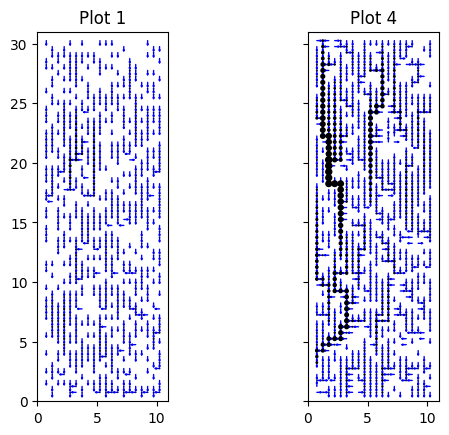

In [70]:
sizeScale = 20. / max (pd.Series (p1SCBC).max (), pd.Series (p4SCBC).max ())
fig, axs = plt.subplots (1, 2)
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0],
                        arrows = True, arrowsize = 2, width = 1,
                        edge_color = "b")
nx.draw_networkx_nodes (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0], node_size = pd.Series (p1SCBC) * sizeScale, node_color = "k")
nx.draw_networkx_edges (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1],
                        arrows = True, arrowsize = 2, width = 1,
                        edge_color = "b")
nx.draw_networkx_nodes (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1], node_size = pd.Series (p4SCBC) * sizeScale, node_color = "k")
limits = plt.axis ('on')
axs [0].axis ('scaled')
axs [1].axis ('scaled')
axs [0].autoscale (tight = True)
axs [1].autoscale (tight = True)
axs [0].set_xlim ([0, 11])
axs [0].set_ylim ([0, 31])
axs [1].set_xlim ([0, 11])
axs [1].set_ylim ([0, 31])
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [0].title.set_text ("Plot 1")
axs [1].title.set_text ("Plot 4")
plt.savefig (figuresFolder + "p1p4SCBCGraph.png")
plt.show ()


#### Relative Node Efficiency

Relative Node Efficiency (RNE) evaluates the impact of a node’s removal on global connectivity. Positive RNE indicates that removal decreases network connectivity, while negative RNE suggests an increase in global efficiency due to the removal of redundant or inefficient nodes.

To calculate RNE, we first need to calculate the global efficiency of the network, and then calculate the relative change of the global efficiency for each node after removing that node. As we don't want to affect our original network graph, we copy the graph into a temporary graph and then remove the node each time.  (Note that it should be straightforward to change this code into a function to do the calculation.)

Our plotting is slightly different from the code in the previous section because the RNE values can be negative or positive.

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


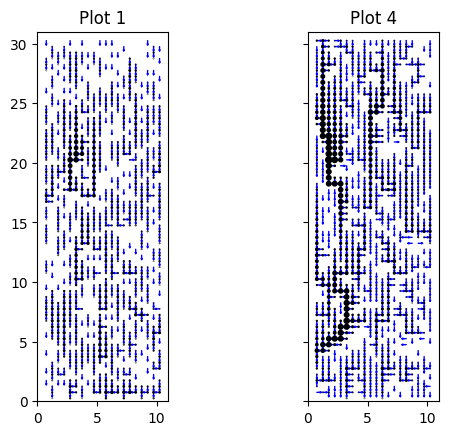

In [71]:
p1SCGE = nx.global_efficiency (p1SCGraph.to_undirected ())
p1SCRNE = []
for i in range (len (p1SCGraph)):
    tempGraph = p1SCGraph.to_undirected ()
    tempGraph.remove_node (i)
    thisRNE = 100. * (p1SCGE - nx.global_efficiency (tempGraph)) / p1SCGE
    p1SCRNE.append (thisRNE)

p4SCGE = nx.global_efficiency (p4SCGraph.to_undirected ())
p4SCRNE = []
for i in range (len (p4SCGraph)):
    tempGraph = p4SCGraph.to_undirected ()
    tempGraph.remove_node (i)
    thisRNE = 100. * (p4SCGE - nx.global_efficiency (tempGraph)) / p4SCGE
    p4SCRNE.append (thisRNE)

sizeScale1 = -min (pd.Series (p1SCRNE).min (), pd.Series (p4SCRNE).min ())
sizeScale2 = 20. / (sizeScale1 + max (pd.Series (p1SCRNE).max (), pd.Series (p4SCRNE).max ()))
fig, axs = plt.subplots (1, 2)
nx.draw_networkx_edges (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0],
                        arrows = True, arrowsize = 2, width = 1,
                        edge_color = "b")
nx.draw_networkx_nodes (p1SCGraph, pos = p1SCGraphGeom, ax = axs [0], node_size = sizeScale1 + pd.Series (p1SCRNE) * sizeScale2, node_color = "k")
nx.draw_networkx_edges (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1],
                        arrows = True, arrowsize = 2, width = 1,
                        edge_color = "b")
nx.draw_networkx_nodes (p4SCGraph, pos = p4SCGraphGeom, ax = axs [1], node_size = sizeScale1 + pd.Series (p4SCRNE) * sizeScale2, node_color = "k")
limits = plt.axis ('on')
axs [0].axis ('scaled')
axs [1].axis ('scaled')
axs [0].autoscale (tight = True)
axs [1].autoscale (tight = True)
axs [0].set_xlim ([0, 11])
axs [0].set_ylim ([0, 31])
axs [1].set_xlim ([0, 11])
axs [1].set_ylim ([0, 31])
axs [0].tick_params (left = True, bottom = True, labelleft = True, labelbottom = True)
axs [1].tick_params (left = True, bottom = True, labelleft = False, labelbottom = True)
axs [0].title.set_text ("Plot 1")
axs [1].title.set_text ("Plot 4")
plt.savefig (figuresFolder + "p1p4SCRNEGraph.png")
plt.show ()


### Automating the Functional Connectivity Analysis

We can take advantage of the logical filenames used for the model results to automate analysis of functional connectivity.  First we need to set up three lists that will contain the labels used for the different scenarios to build up into the filenames.  Then we create lists of the DEM data, the data file objects (to access the geometry data) and the flow-direction data we've already calculated.  By putting these objects in lists, we can refer to them with the same index values we use to extract the relevant plot flow data.  (This is a really useful feature of Python lists -- that we can put any object in them.)  Thirdly, we create some empty lists to store the conditions and calculations so we can plot them out subsequently.

In [72]:
plotLabel = ["1", "2", "3", "4"]
rainfallLabel = ["A", "B", "C", "D", "E"]
soilMoistureLabel = ["_lowsm", "_medsm", "_highsm"]
demData = [p1DEM, p2DEM, p3DEM, p4DEM]
demDataFile = [p1DEMFile, p2DEMFile, p3DEMFile, p4DEMFile]
flowDirData = [p1FlowDir, p2FlowDir, p3FlowDir, p4FlowDir]
plotOutput = []
rainOutput = []
smOutput = []
flowOutput = []
centDegOutput = []


We can then loop through each of the plots for each of the rainfall conditions and each of the soil-moisture conditions.  We create the appropriate filename based on the values in the lists above, and read in the flow data for those conditions.  When creating the flow directed graph, we use the lists above to pass the relevant DEM and flow-direction data, as well as the flow data just read in for the file.
The calculation for the centralization degree is the same as above, except that we've added a condition that catches the case when there is no network, and set the value to.
Finally in this block, we add the relevant conditions and calculations to our lists.

In [73]:
for plot in range (len (plotLabel)):
    for rain in range (len (rainfallLabel)):
        for soilMoisture in range (len (soilMoistureLabel)):
            filename = dataFolder + "p" + plotLabel [plot] + "_rain" + rainfallLabel [rain] + soilMoistureLabel [soilMoisture] + "_dschg.asc"
            with (rio.open (filename)) as dataFile:
                data = dataFile.read (1)
            thisFCGraph, thisFCGraphGeom = createFlowFCDigraph (demData [plot],
                                                                demDataFile [plot],
                                                                flowDirData [plot],
                                                                data,
                                                                flowThreshold = 0.249,
                                                                maxFlow = 3.86)
            theseEdges = thisFCGraph.edges ()
            theseWeights = [thisFCGraph [u][v]['weight'] for u,v in theseEdges]
            thisDegCent = nx.degree_centrality (thisFCGraph)
            thisDegCentNonZero = pd.Series (thisDegCent)[pd.Series (thisDegCent) > 0]
            n = thisDegCentNonZero.count ()
            if (n > 2):
                thisCentDeg = sum (max (thisDegCentNonZero) - thisDegCentNonZero) / (n - 2)
            else:
                thisCentDeg = 0.

            plotOutput.append ("Plot " + plotLabel [plot])
            rainOutput.append ("Rain " + rainfallLabel [rain])
            smOutput.append (soilMoistureLabel [soilMoisture] [1:])
            flowOutput.append (data.sum ())
            centDegOutput.append (thisCentDeg)


To plot the output of these calculations, we gather all our lists into a dataframe so that we can graph the outputs easily.

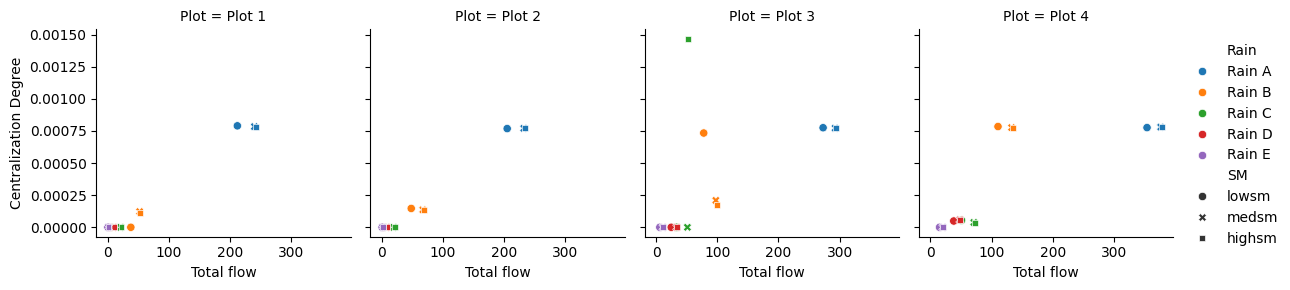

In [74]:
flowFCOutput = pd.DataFrame ({"Plot": plotOutput,
                              "Rain": rainOutput,
                              "SM": smOutput,
                              "Total flow": flowOutput,
                              "Centralization Degree": centDegOutput})

gridPlot = sns.FacetGrid (data = flowFCOutput,
                          col = "Plot", col_wrap = 4)
gridPlot.map_dataframe (sns.scatterplot, x = "Total flow",
                        y = "Centralization Degree", hue = "Rain", style = "SM")
gridPlot.add_legend ()
plt.savefig (figuresFolder + "FlowFCCDGraph.png")
plt.show ()


Note the power of the seaborn library in allowing us to produce four scatterplots with the points colour coded by rainfall condition and shapes controlled by the soil-moisture conditions.  We could produce this graphic using matplotlib, but it would take many more lines of code.

The calculations above illustrate the procedure just for centralization degree.  It would be straightforward to extend this process to the other connectivity calculations we carried out above.


### References

Harel M-A, E Mouche 2014 'Is the connectivity function a good indicator of soil infiltrability distribution and runoff flow dimension?', Earth Surface Processes and Landforms 39, 1514-1525. doi: 10.1002/esp.3604

Tiwari S, L Turnbull, J Wainwright 2025 ‘Quantification of local- and global-scale hydrological and sediment connectivity over grassland and shrubland hillslopes’, Journal of Hydrology 655. doi: 10.1016/j.jhydrol.2025.132896

Turnbull L, J Wainwright 2019 ‘From structure to function: understanding shrub encroachment in drylands using hydrological and sediment connectivity’, Ecological Indicators 98, 608–618. doi: 10.1016/j.ecolind.2018.11.039.

Turnbull L, J Wainwright, RE Brazier 2010a ‘Changes in hydrology and erosion over a transition from grassland to shrubland’. Hydrological Processes 24, 393–414.

Turnbull L, J Wainwright, RE Brazier 2010b ‘Hydrology, erosion and nutrient transfers over a transition from semi-arid grassland to shrubland in the South-Western USA: a modelling assessment’. Journal of Hydrology 388, 258–272, DOI:10.1016/j.jhydrol.2010.05.005.

Turnbull L, J Wainwright, RE Brazier, R Bol 2010c ‘Biotic and abiotic changes in ecosystem structure over a shrub-encroachment gradient in the southwestern USA’. Ecosystems 13, 1239–1255. DOI: 10.1007/s10021-010-9384-8.

Turnbull L, J Wainwright, RE Brazier 2011 ‘Nitrogen and phosphorus dynamics during runoff events over a transition from grassland to shrubland in the south-western United States’. Hydrological Processes 25, 1–17. DOI: 10.1002/hyp.7806

Wainwright J, AJ Parsons, EN Müller, RE Brazier, DM Powell, B Fenti 2008a ‘A transport-distance approach to scaling erosion rates:  1. background and model development’, Earth Surface Processes and Landforms 33, 813–826. DOI: 10.1002/esp.1624

Wainwright J, AJ Parsons, EN Müller, RE Brazier, DM Powell, B Fenti 2008b ‘A transport-distance approach to scaling erosion rates:  2. Sensitivity and evaluation of MAHLERAN’, Earth Surface Processes and Landforms 33, 962–984. DOI: 10.1002/esp.1623

Wainwright J, AJ Parsons, EN Müller, RE Brazier, DM Powell, B Fenti 2008c  ‘A transport-distance approach to scaling erosion rates:  3. Evaluating scaling characteristics of MAHLERAN’, Earth Surface Processes and Landforms 33, 1113–1128, DOI: 10.1002/esp.1622
